In [5]:
import Pude_training_loop.loss_functions_torch as loss_functions
import Pude_training_loop.pude_utils as pude_utils
import Pude_training_loop.model_training as model_training
import Pude_training_loop.dataset_loader as data_loader
from Pude_training_loop.physics_parameter_estmation import UnderwaterParameterFinder
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"


# depth_anything_model, depth_anything_image_processor = model_training.get_model_image_processor_pair(model_name="depth_anything", model_path=model_training.models["depth_anything"], device=device)
# new_pude_model, new_pude_mode_image_processor = model_training.get_model_image_processor_pair(model_name="depth_anything", model_path=model_training.models["depth_anything"], device=device)
depth_anything_model, new_pude_model, depth_anything_image_processor, new_pude_mode_image_processor = model_training.get_two_separate_model_pairs(model_path=model_training.models["depth_anything"])
dataset_loader = data_loader.DatasetLoader() # Initialize dataset loader with default parameters
underwater_parameter_estimator = UnderwaterParameterFinder() # Initialize underwater parameter finder with default parameters
pude_loss_fn = loss_functions.PUDELoss() # Initialize Pude loss function with default parameters
# Define training parameters
epochs = 3
learning_rate = 1e-5
batch_size = 1

# Define optimizer
optimizer = torch.optim.Adam(new_pude_model.parameters(), lr=learning_rate)

new_pude_model.train()

for epochs in range(epochs):
    for i in range(len(dataset_loader)):
        non_linear_images, linear_images = dataset_loader[i]
        # linear_images = linear_images.to(device)
        # Similarly, convert non_linear_images to a PyTorch tensor
        # non_linear_images_tensor = torch.tensor(non_linear_images, device=device)

        # Forward pass
        depth_anything_output = model_training.get_model_output(model=depth_anything_model, 
                                                                image_processor=depth_anything_image_processor, 
                                                                raw_image=non_linear_images)
        pude_output = model_training.get_model_output(model=new_pude_model, 
                                                     image_processor=new_pude_mode_image_processor, 
                                                     raw_image=non_linear_images)
        # parameter estimation
        hat_nu, hat_mu, hat_B_infty = underwater_parameter_estimator.algorithm_1(d_D=depth_anything_output, I=linear_images)
        # Loss calculation
        loss = pude_loss_fn( torch.from_numpy(pude_output), torch.from_numpy(depth_anything_output), 
                            torch.from_numpy(linear_images), torch.from_numpy(hat_nu), 
                            torch.tensor(hat_mu), torch.from_numpy(hat_B_infty))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print(f"processed {i+1} images")


# Save the model
# torch.save(new_pude_model.state_dict(), "new_pude_model.pth")

processed 20 images
processed 40 images
processed 60 images
processed 80 images
processed 100 images
processed 20 images
processed 40 images
processed 60 images
processed 80 images
processed 100 images
processed 20 images
processed 40 images
processed 60 images
processed 80 images
processed 100 images


In [ ]:
import Pude_training_loop.model_training as model_training
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
depth_anything_model, depth_anything_image_processor = model_training.get_model_image_processor_pair(model_name="depth_anything", model_path=model_training.models["depth_anything"], device=device)
new_pude_model, new_pude_mode_image_processor = model_training.get_model_image_processor_pair(model_name="depth_anything", model_path=model_training.models["depth_anything"], device=device)


In [10]:
# test the model on a single image
from PIL import Image
non_linear_images, linear_images = dataset_loader[99]
depth_anything_output = model_training.get_model_output(model=depth_anything_model, 
                                                        image_processor=depth_anything_image_processor, 
                                                        raw_image=non_linear_images)
pude_output = model_training.get_model_output(model=new_pude_model,
                                                image_processor=new_pude_mode_image_processor,
                                                raw_image=non_linear_images)


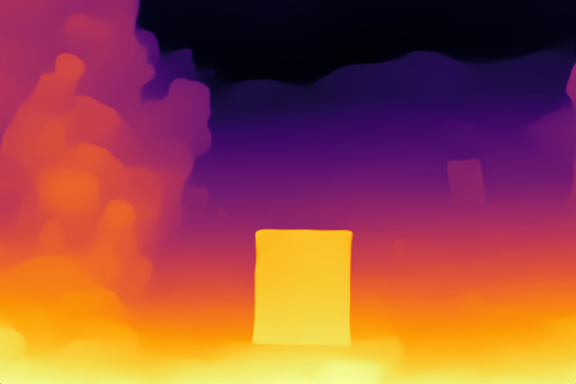

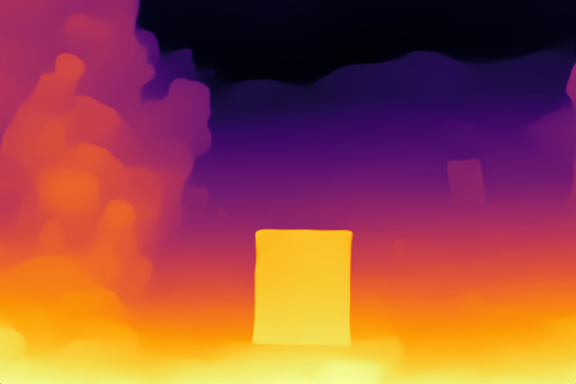

In [20]:
import numpy as np
import cv2

depth_anything_output = depth_anything_output.reshape(384, 576)
formatted = (depth_anything_output * 255 / np.max(depth_anything_output)).astype("uint8")
colored_depth = cv2.applyColorMap(formatted, cv2.COLORMAP_INFERNO)[:, :, ::-1]
depth = Image.fromarray(colored_depth)
display(depth)
pude_output = pude_output.reshape(384, 576)
formatted = (pude_output * 255 / np.max(pude_output)).astype("uint8")
colored_pude = cv2.applyColorMap(formatted, cv2.COLORMAP_INFERNO)[:, :, ::-1]
pude = Image.fromarray(colored_pude)
display(pude)





In [21]:
# see if both results are same
print(np.allclose(depth_anything_output, pude_output))

True
